# [IT8302] Applied Machine Learning: Wine Clustering

## Table of Contents
1. [Import Libraries](#1)
2. [Exploratory Data Analysis](#2)
3. [Data Pre-Processing](#3)
4. [Modelling](#4)
5. [Conclusion](#5)

__Introduction__  
This analysis uses the wine dataset from UCI to explore clustering techniques in unsupervised machine learning. The aim is to create a model that groups different types of wine based on their chemical properties derived from an analysis of wine produced in a specific region of Italy. By applying clustering, we can organise unlabelled data into distinct groups, enabling further insights and analysis without relying on predefined labels.

In this study, we evaluate the performance of 4 clustering models to determine the optimal number of clusters and identify the best-performing model. The models explored are:
1.	__KMeans__
2.	__DBSCAN__
3.	__Gaussian Mixture Model__
4.	__Agglomerative Clustering__

Each model is assessed using various evaluation metrics to ensure robust and reliable results.

__Datasets used__  
[Wine Dataset](https://archive.ics.uci.edu/ml/datasets/wine)

# 1. Import Libraries <a id = '1'></a>

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import (
    adjusted_mutual_info_score,
    davies_bouldin_score,
    fowlkes_mallows_score,
    silhouette_score,
)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
from yellowbrick.cluster import SilhouetteVisualizer

warnings.filterwarnings("ignore")

# 2. Exploratory Data Analysis (EDA) <a id = '2'></a> 

To begin, we load the UCI wine dataset and inspect it for the following:
- Column data types;
- Null values, if any; and
- Descriptive statistics for each column to determine if scaling is required for clustering as clustering algorithms relying on Euclidean distance are highly sensitive to differences in scale.

In [2]:
# Fetch wine dataset
wine = fetch_ucirepo(id=109)

# Store X and y data separately
X = wine["data"]["features"]
y = wine["data"]["targets"]

# Inspect column data types and nulls
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malicacid                     178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity_of_ash             178 non-null    float64
 4   Magnesium                     178 non-null    int64  
 5   Total_phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid_phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color_intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  0D280_0D315_of_diluted_wines  178 non-null    float64
 12  Proline                       178 non-null    int64  
dtypes: fl

In [3]:
# Inspect descriptive statistics of all features
X.describe()

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


# 3. Data Pre-Processing <a id = '3'></a> 

Based on the descriptive statistics described above, the mean values of all features vary considerably, with some ranging from the tens to the hundreds. To prevent our clustering algorithms from being biased toward features with larger scales, we normalize all numerical features to have a mean of 0 and a standard deviation of 1 before performing clustering analysis.

Additionally, since the dataset includes actual labels, we will use this information to validate the clustering predictions in this project.

To facilitate visualisation, we apply t-distributed stochastic neighbour embedding (t-SNE) to reduce feature dimensions from 13 to 2, allowing us to visualise the wine dataset clusters and analyse the underlying groupings.

In [4]:
# Instantiate scaler and normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create numpy array of actual labels for cluster vlaidation (since labels are available)
y_actual = y.to_numpy().reshape(-1)

# Visualise clusters using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=10)
X_tsne = tsne.fit_transform(X_scaled)

# 4. Modelling <a id = '4'></a> 

To streamline model building and experimentation, we create a model evaluation function and a clustering visualisation function for quick and straightforward assessment. Our evaluation function incorporates the following metrics:

1.	__Silhouette Coefficient__: Assesses clustering quality by comparing between-cluster separation and within-cluster compactness. This metric is particularly useful when actual labels are unknown. Scores range from -1 to 1, with values closer to 1 indicating better clustering performance.

2.	__Davies-Bouldin Score__: Measures model performance based on cluster separation and compactness. Lower scores indicate better partitioning, with 0 being the best possible score.

3.	__Adjusted Mutual Information (AMI) Score__: Compares predicted cluster labels with actual labels by quantifying the level of agreement, normalized for chance. Scores range from 0 to 1, with 1 representing perfect similarity or matching.

4.	__Fowlkes-Mallows Score__: Evaluates the similarity between predicted and actual clustering results by calculating the geometric mean of pairwise precision and recall, making it robust to label permutations. Scores range from 0 to 1, with 1 indicating high similarity or perfect assignment.

In [5]:
def calculate_cluster_metrics(
    model: str, y_pred: np.ndarray, y_actual=y_actual
) -> None:
    """Generate summarised clustering metrics for the specified model based on model predictions and actual labels, where applicable

    Args:
        model (str): Name of model for logging
        y_pred (np.ndarray): Predicted cluster values of the model
        y_actual (np.ndarray, optional): Actual cluster labels (if available)
    """
    logger.debug(f"Evaluating {model}...")

    try:
        silhouette_coef = silhouette_score(X_scaled, y_pred, metric="euclidean")
        logger.info(f"Silhouette coefficient = {silhouette_coef:.2f}")
    except Exception as e:
        pass

    try:
        db_score = davies_bouldin_score(X_scaled, y_pred)
        logger.info(f"Davies-Bouldin score = {db_score:.2f}")
    except Exception as e:
        pass

    try:
        ami_score = adjusted_mutual_info_score(y_actual, y_pred)
        logger.info(f"Adjusted mutual information score = {ami_score:.2f}")
    except Exception as e:
        pass

    try:
        fm_score = fowlkes_mallows_score(y_actual, y_pred)
        logger.info(f"Fowlkes-Mallows score = {fm_score:.2f}")
    except Exception as e:
        pass

In [6]:
def generate_cluster_plot(model: str, y_pred: np.ndarray) -> None:
    """Generates a cluster plot using the specified model's predictions

    Args:
        model (str): Name of model for logging
        y_pred (np.ndarray): Predicted cluster values of the model
    """
    # Visualise clusters using t-SNE
    g = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred, cmap="viridis")
    plt.title(f"t-SNE Cluster Visualisation for {model}", fontweight="bold")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(*g.legend_elements(), title="Clusters", frameon=True, loc="best")

    plt.show()

Since we have access to labelled data, we use the labels to evaluate the performance of our clustering models and to visualise the wine clusters using t-SNE. This serves as a baseline for future model evaluations during experimentation.

In our evaluation metrics, only the silhouette coefficient and Davies-Bouldin score provide meaningful baseline comparisons as the adjusted mutual information score and Fowlkes-Mallows score return a similarity value of 1 when comparing the actual labels to themselves.

From the cluster plot, we observe that there are three clusters with some overlap between clusters 1, 2, and 3. This suggests that our clustering algorithms may face challenges in separating the clusters cleanly based on the available data.

2025-01-25 12:20:34.220 | DEBUG    | __main__:calculate_cluster_metrics:11 - Evaluating actuals...
2025-01-25 12:20:34.222 | INFO     | __main__:calculate_cluster_metrics:15 - Silhouette coefficient = 0.28
2025-01-25 12:20:34.224 | INFO     | __main__:calculate_cluster_metrics:21 - Davies-Bouldin score = 1.41
2025-01-25 12:20:34.225 | INFO     | __main__:calculate_cluster_metrics:27 - Adjusted mutual information score = 1.00
2025-01-25 12:20:34.226 | INFO     | __main__:calculate_cluster_metrics:33 - Fowlkes-Mallows score = 1.00


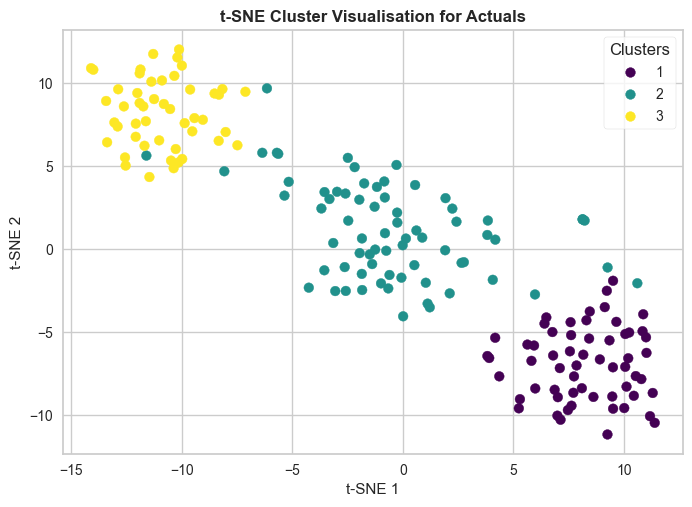

In [7]:
# Calculate clustering metrics
calculate_cluster_metrics(model="actuals", y_pred=y_actual)

# Visualise clusters using t-SNE
generate_cluster_plot(model="Actuals", y_pred=y_actual)

## KMeans Clustering <a id = '4_1'></a>

We begin by applying the KMeans clustering algorithm to group the wine data. Initially, centroids (cluster centres) are randomly generated and data points are assigned to clusters based on the squared Euclidean distance. The centroids are then re-calculated by taking the mean of all points within each cluster. This process is repeated iteratively until convergence is reached where no further reassignments occur and the sum of squared Euclidean distances is minimised.

While the number of clusters is known in this dataset, the true number of clusters in the data is unknown in reality. Hence, to determine the optimal number of clusters, we cluster the data with different values of `n_clusters` and assess the results using appropriate metrics, allowing us to objectively identify the best number of clusters.

We employ the elbow method using inertias (sum of squared Euclidean distance of each data point to its cluster centroid) in addition to the evaluation metrics outlined above to evaluate our KMeans model for different values of `n_clusters` and check for convergence.

2025-01-25 12:20:34.442 | INFO     | __main__:<module>:8 - For 1 cluster(s), inertia = 2314.00
2025-01-25 12:20:34.444 | INFO     | __main__:<module>:8 - For 2 cluster(s), inertia = 1659.01
2025-01-25 12:20:34.447 | INFO     | __main__:<module>:8 - For 3 cluster(s), inertia = 1277.93
2025-01-25 12:20:34.449 | INFO     | __main__:<module>:8 - For 4 cluster(s), inertia = 1197.22
2025-01-25 12:20:34.451 | INFO     | __main__:<module>:8 - For 5 cluster(s), inertia = 1121.33
2025-01-25 12:20:34.453 | INFO     | __main__:<module>:8 - For 6 cluster(s), inertia = 1100.15
2025-01-25 12:20:34.455 | INFO     | __main__:<module>:8 - For 7 cluster(s), inertia = 1038.94
2025-01-25 12:20:34.457 | INFO     | __main__:<module>:8 - For 8 cluster(s), inertia = 975.92
2025-01-25 12:20:34.459 | INFO     | __main__:<module>:8 - For 9 cluster(s), inertia = 945.10
2025-01-25 12:20:34.462 | INFO     | __main__:<module>:8 - For 10 cluster(s), inertia = 937.05


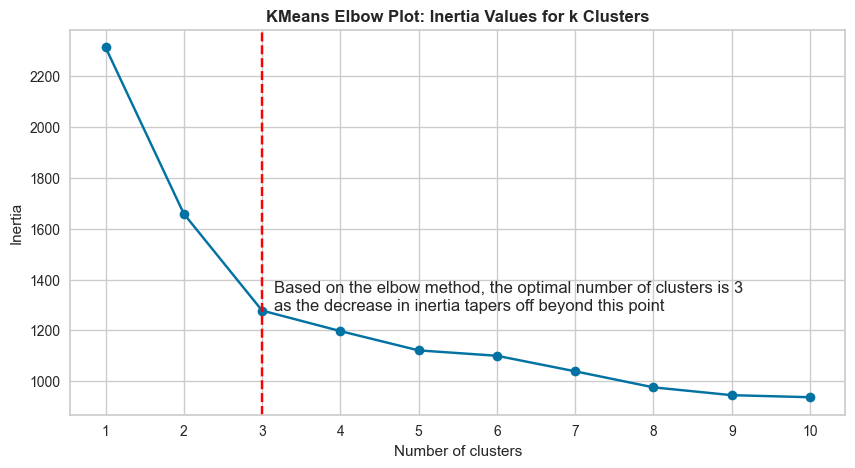

In [8]:
# Determine number of clusters to set for KMeans using elbow method
inertia_scores = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    inertia = kmeans.inertia_
    inertia_scores.append(inertia)
    logger.info(f"For {i} cluster(s), inertia = {inertia:.2f}")

# Elbow plot using inertias
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 11), inertia_scores, marker="o")
plt.axvline(3, linestyle="--", color="red")
plt.text(
    3.15,
    1280,
    "Based on the elbow method, the optimal number of clusters is 3 \nas the decrease in inertia tapers off beyond this point",
)
plt.title("KMeans Elbow Plot: Inertia Values for k Clusters", fontweight="bold")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.xticks(np.arange(1, 11))
plt.show()

From the elbow plot below, the rate of decrease in inertia slows significantly after 3 clusters, suggesting that the optimal number of clusters is around `n_clusters = 3` and adding more clusters yields diminishing returns. Therefore, we will proceed by evaluating our KMeans model with `n_clusters = 3`. 

As shown our model evaluation below, the silhouette coefficient is also highest for `n_clusters = 3`. Additionally, the t-SNE cluster plot closely resembles the distribution of the actual labels.

2025-01-25 12:20:34.539 | DEBUG    | __main__:<module>:5 - Calculating silhouette coefficients for KMeans models with 2-10 clusters
2025-01-25 12:20:34.543 | INFO     | __main__:<module>:12 - For 2 clusters, silhouette coefficient = 0.27
2025-01-25 12:20:34.547 | INFO     | __main__:<module>:12 - For 3 clusters, silhouette coefficient = 0.29
2025-01-25 12:20:34.550 | INFO     | __main__:<module>:12 - For 4 clusters, silhouette coefficient = 0.26
2025-01-25 12:20:34.553 | INFO     | __main__:<module>:12 - For 5 clusters, silhouette coefficient = 0.24


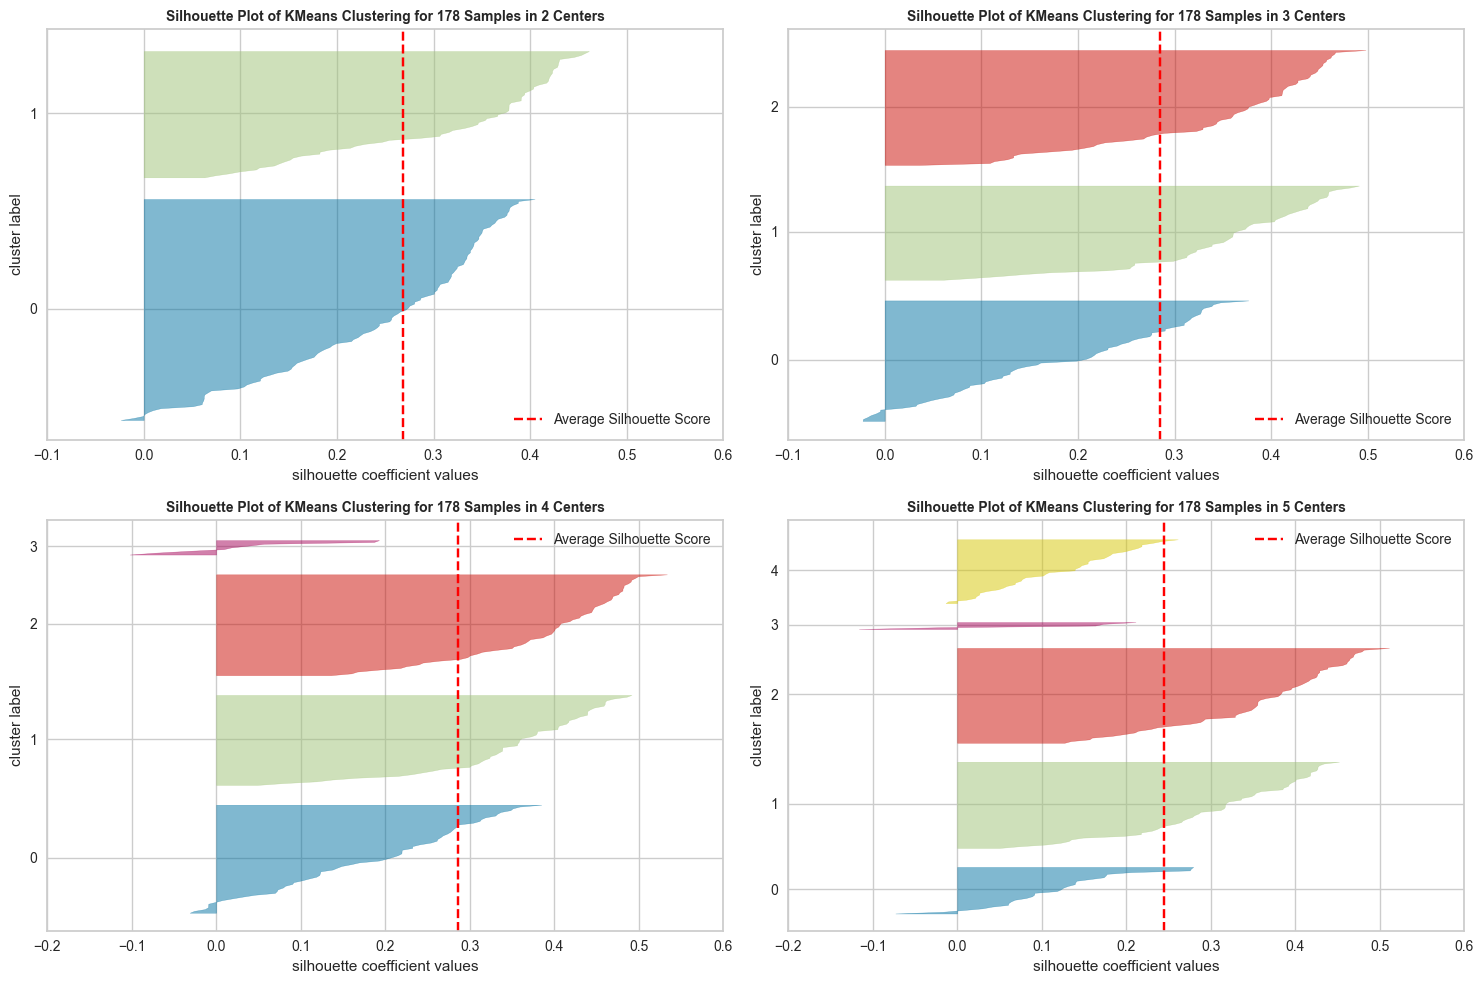

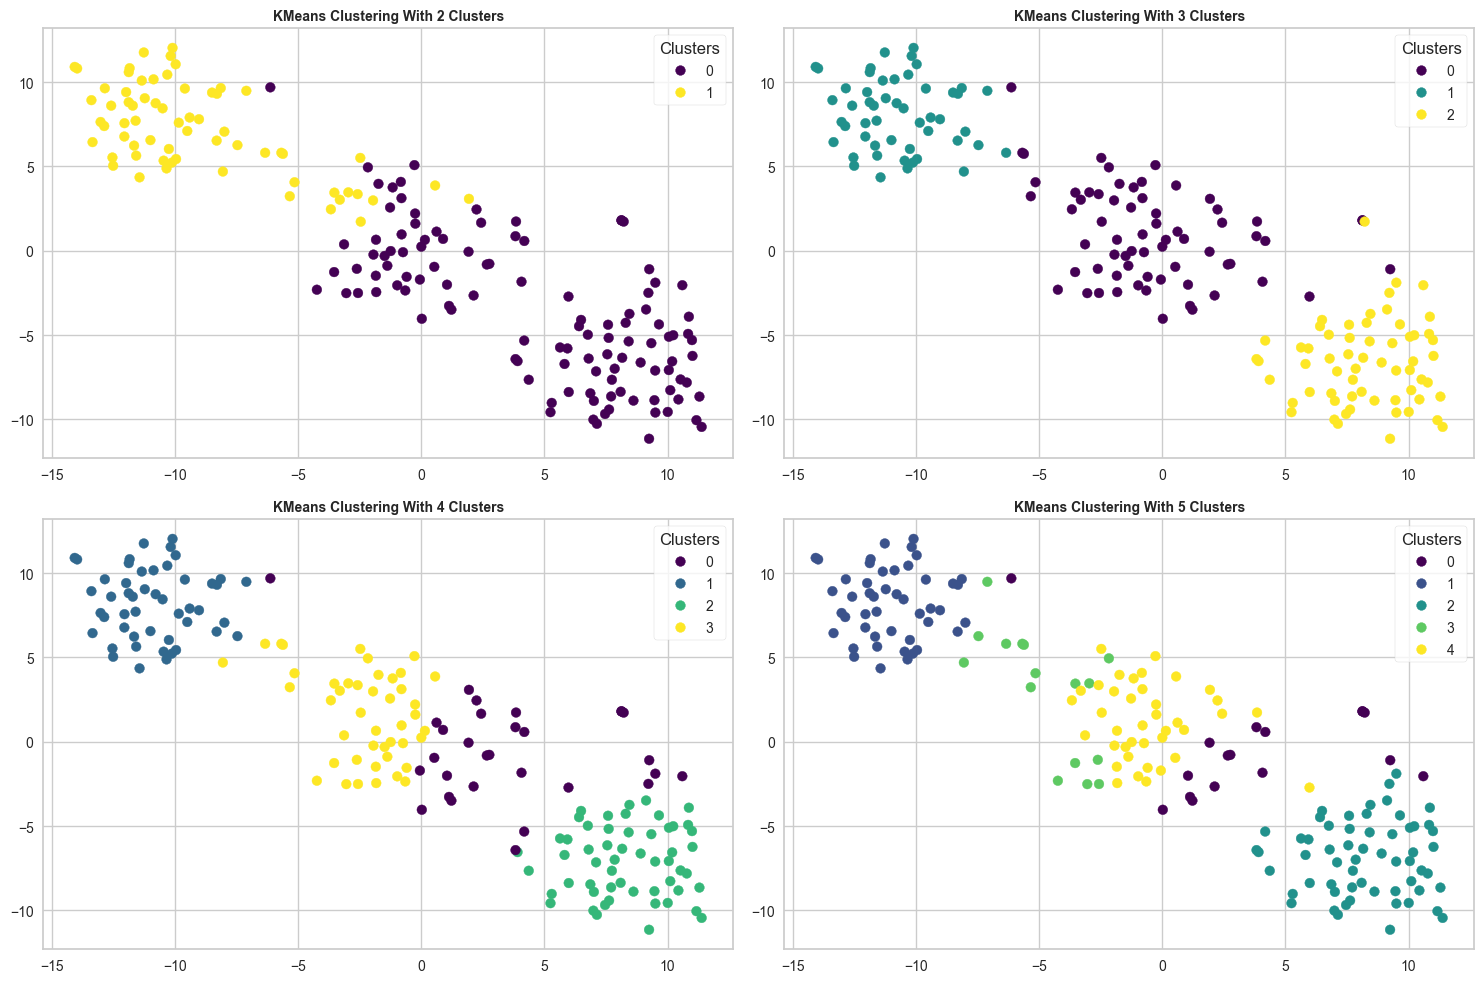

In [9]:
# Create empty list to store predicted cluster labels
y_pred = []

# Calculate silhouette coefficient for up to 5 clusters
logger.debug("Calculating silhouette coefficients for KMeans models with 2-10 clusters")

for i in range(2, 6):
    kmeans = KMeans(n_clusters=i, random_state=1).fit(X_scaled)
    labels = kmeans.predict(X_scaled)
    silhouette_coef = silhouette_score(X_scaled, labels, metric="euclidean")
    centers = kmeans.cluster_centers_
    logger.info(f"For {i} clusters, silhouette coefficient = {silhouette_coef:.2f}")

    y_pred.append(kmeans.predict(X_scaled))

# Visualise silhouette coefficients
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for i in range(2, 6):
    visualizer = SilhouetteVisualizer(
        KMeans(n_clusters=i, random_state=0), ax=axes[i - 2], colors="yellowbrick"
    )
    visualizer.fit(X_scaled)
    visualizer.finalize()
    axes[i - 2].set_title(axes[i - 2].get_title(), fontweight="bold", fontsize=10)

plt.tight_layout()
plt.show()

# Visualise clusters using t-SNE
plt.figure(figsize=(15, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    g = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred[i], cmap="viridis")
    plt.title(f"KMeans Clustering With {i+2} Clusters", fontsize=10, fontweight="bold")
    plt.legend(*g.legend_elements(), title="Clusters", frameon=True, loc="upper right")

plt.tight_layout()
plt.show()

Using the Davies-Bouldin score, AMI score, and Fowlkes-Mallows score, these evaluation metrics align with the elbow method and silhouette score. The AMI and FM scores are highest at `n_clusters = 3`, while the Davies-Bouldin score is lowest at the same value.

This supports our choice of `n_clusters = 3` as the optimal model hyperparameter for clustering the wine dataset. This hyperparameter setting can be applied to future data, assuming the number of wine types being assessed remains unchanged.

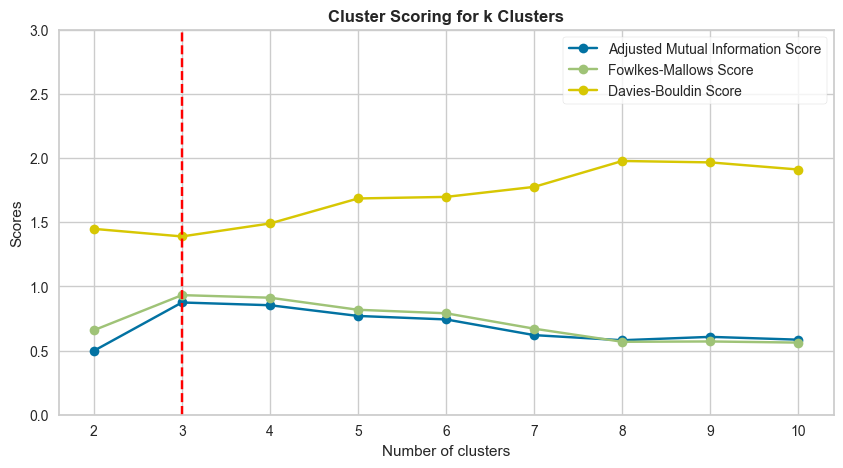

In [10]:
# Create empty list to store evaluation metrics for each value of n_clusters
ami_scores = []
fm_scores = []
db_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    y_pred = kmeans.predict(X_scaled)
    ami_score = adjusted_mutual_info_score(y_actual, y_pred)
    fm_score = fowlkes_mallows_score(y_actual, y_pred)
    db_score = davies_bouldin_score(X_scaled, y_pred)

    ami_scores.append(ami_score)
    fm_scores.append(fm_score)
    db_scores.append(db_score)

# Plot scores
plt.figure(figsize=(10, 5))
plt.plot(
    np.arange(2, 11),
    ami_scores,
    marker="o",
    c="b",
    label="Adjusted Mutual Information Score",
)
plt.plot(np.arange(2, 11), fm_scores, marker="o", c="g", label="Fowlkes-Mallows Score")
plt.plot(np.arange(2, 11), db_scores, marker="o", c="y", label="Davies-Bouldin Score")
plt.axvline(3, linestyle="--", color="red")
plt.title("Cluster Scoring for k Clusters", fontweight="bold")
plt.xlabel("Number of clusters")
plt.ylabel("Scores")
plt.legend(frameon=True)
plt.xticks(np.arange(2, 11))
plt.ylim(0, 3)
plt.show()

Our KMeans model with `n_clusters = 3` performed relatively well, achieving a silhouette coefficient of 0.29, a Davies-Bouldin score of 1.39, an AMI score of 0.89, and a Fowlkes-Mallows score of 0.94.

Interestingly, aside from the AMI and Fowlkes-Mallows scores, the silhouette coefficient and Davies-Bouldin score for the KMeans clusters appear to outperform those calculated for the clusters based on the actual labels, suggesting that KMeans may identify structures in the data that are slightly more compact and well-separated.

2025-01-25 12:20:35.170 | DEBUG    | __main__:calculate_cluster_metrics:11 - Evaluating KMeans...
2025-01-25 12:20:35.173 | INFO     | __main__:calculate_cluster_metrics:15 - Silhouette coefficient = 0.29
2025-01-25 12:20:35.175 | INFO     | __main__:calculate_cluster_metrics:21 - Davies-Bouldin score = 1.39
2025-01-25 12:20:35.176 | INFO     | __main__:calculate_cluster_metrics:27 - Adjusted mutual information score = 0.89
2025-01-25 12:20:35.177 | INFO     | __main__:calculate_cluster_metrics:33 - Fowlkes-Mallows score = 0.94


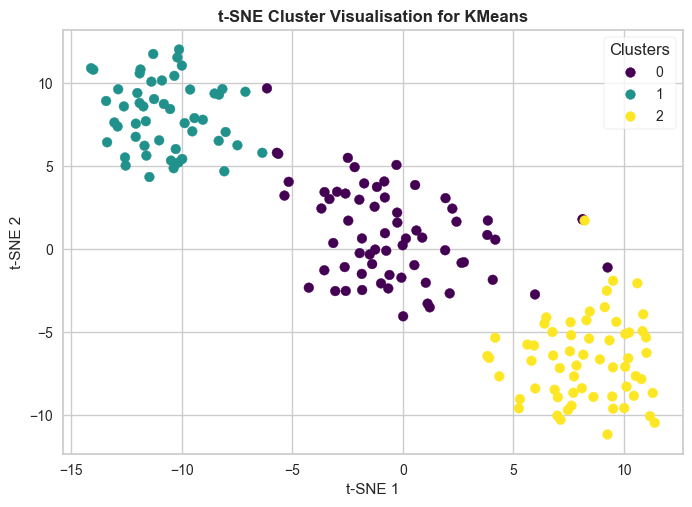

In [11]:
# Initialise and fit DBSCAN model
kmeans = KMeans(n_clusters=3, random_state=1)
y_kmeans = kmeans.fit_predict(X_scaled)

# Calculate clustering metrics
calculate_cluster_metrics(model="KMeans", y_pred=y_kmeans)

# Visualise clusters using t-SNE
generate_cluster_plot(model="KMeans", y_pred=y_kmeans)

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

In this section, we explore alternative clustering algorithms such as DBSCAN, to cluster the wine dataset and achieve comparable results. Unlike KMeans, DBSCAN, a density-based clustering algorithm, is particularly effective at handling outliers and noisy datasets, and it does not require pre-defining the number of clusters.

To build our DBSCAN model, we need to select appropriate values for eps (ε) and `min_samples`. Following the recommendations by [Schubert et al. (2017)](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf), we apply the heuristic suggested by Sander et al. (1998), where the $(2·dim−1)^{th}$ nearest neighbour is used for determining eps, and min_samples is set to $2·dim$.

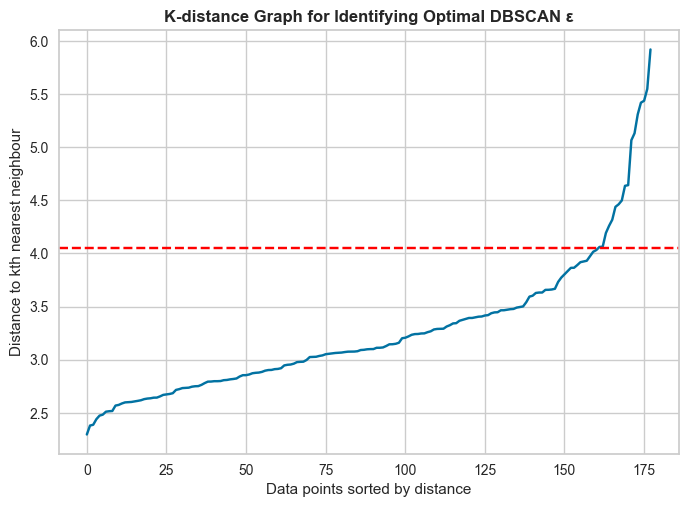

In [12]:
# Calculate minimum number of samples
min_samples = 2 * X.shape[1]

# Get distances to kth nearest neighbour where k = min_samples - 1
neighbours = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, _ = neighbours.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, min_samples - 2]

# Plot K-distance graph
plt.plot(distances)
plt.xlabel("Data points sorted by distance")
plt.ylabel("Distance to kth nearest neighbour")
plt.title("K-distance Graph for Identifying Optimal DBSCAN ε", fontweight="bold")
plt.axhline(y=4.05, color="red", linestyle="--")
plt.show()

Based on the K-distance graph generated using `min_samples = 26` and plotting the sorted distances of all points to their $25^{th}$ nearest neighbour, the graph provides a visual means to select an appropriate ε value. The aim is to identify a sharp increase in distance—a distinct “elbow” in the graph—which marks the point where most data points beyond this distance are considered noise. In this case, the graph shows a significant spike at around 4.05, indicating that this value of ε can effectively distinguish core points from noise and border points for the DBSCAN clustering process.

With this, we proceed by setting the hyperparameters to `min_samples = 26` and `eps = 4.05` for our DBSCAN model and evaluate its performance using our pre-defined clustering metrics as detailed below.

2025-01-25 12:20:35.421 | DEBUG    | __main__:calculate_cluster_metrics:11 - Evaluating DBSCAN...
2025-01-25 12:20:35.423 | INFO     | __main__:calculate_cluster_metrics:15 - Silhouette coefficient = 0.26
2025-01-25 12:20:35.424 | INFO     | __main__:calculate_cluster_metrics:21 - Davies-Bouldin score = 1.86
2025-01-25 12:20:35.425 | INFO     | __main__:calculate_cluster_metrics:27 - Adjusted mutual information score = 0.03
2025-01-25 12:20:35.426 | INFO     | __main__:calculate_cluster_metrics:33 - Fowlkes-Mallows score = 0.56


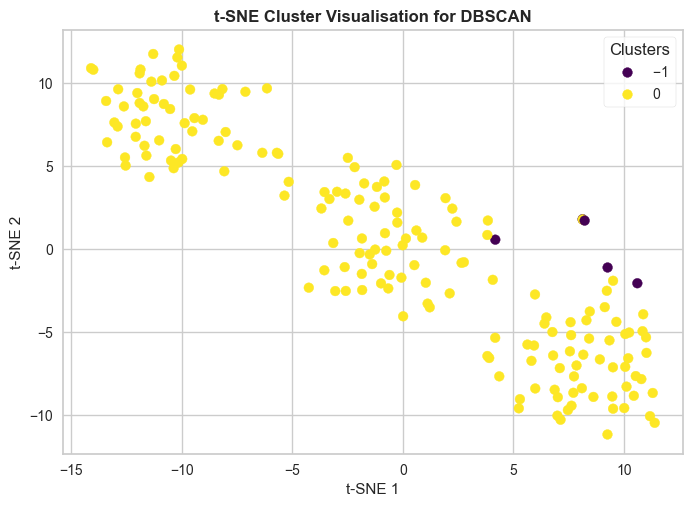

In [13]:
# Initialise and fit DBSCAN model
dbscan = DBSCAN(eps=4.05, min_samples=min_samples)
y_dbscan = dbscan.fit_predict(X_scaled)

# Calculate clustering metrics
calculate_cluster_metrics(model="DBSCAN", y_pred=y_dbscan)

# Visualise clusters using t-SNE
generate_cluster_plot(model="DBSCAN", y_pred=y_dbscan)

The above results and cluster plot indicate that DBSCAN performed worse than KMeans in clustering the wine datsaet. DBSCAN identified only 1 cluster (label of "-1" represents noisy data points, not a cluster) instead of 3 which differs from the known structure of the dataset. In addition, evaluation metrics show a decrease in performance compared to KMeans: the silhouette coefficient decreased from 0.29 to 0.26, and Davies-Bouldin score increased from 1.39 to 1.86, indicating poorer cluster compactness and separation. For metrics that require actual labels such as the AMI and Fowlkes-Mallows score, the results also show a decrease in similarity to the true labels. Overall, DBSCAN does not perform as well as KMeans for this specific dataset.

Potential reasons for DBSCAN's poorer performance may include:
1. __Cluster Shape Assumptions__: DBSCAN forms clusters based on density which often leads to arbitrarily shaped clusters such as that shown in the plot above. In contrast, KMeans assumes clusters that are roughly spherical which, in this instance, may better fit the actual clustering of the wine dataset.

2. __Hyperparameter Sensitivity__: DBSCAN is highly sensitive to the choice of `eps` and `min_samples`. Should these hyperparameters be improperly selected, the model may fail to identify the true cluster structure of the dataset. In the example above, futher hyperparameter tuning may be required to obtain better results.

3. __Overlapping Clusters__: DBSCAN may struggle with overlapping clusters which are evident in the t-SNE visualisation of the wine dataset, potentially resulting in misassignment of data points to the wrong clusters.

4.	__Feature Space Complexity__: The wine dataset has 13 features, making it a relatively high-dimensional space. High dimensionality can dilute density differences, making it harder for DBSCAN to distinguish clusters effectively.

5. 	__Density-Based Clustering Limitations__: DBSCAN assumes globally homogenous density for clustering which can cause issues when clusters have varying densities, as is possible in the wine dataset.

## Gaussian Mixture Model (GMM)

In this section, we explore GMMs as an alternative to KMeans. Unlike KMeans which assumes that clusters are spherical, GMMs use probabilistic and maximum likelihood estimation methods, allowing for the identification of clusters with more flexible shapes such as ellipses. GMMs model the data as a mixture of multiple Gaussian distributions, where each cluster corresponds to a Gaussian component. Each component is defined by:
1. A mean vector ($ \mu $) representing the centre of the cluster.
2. A covariance matrix ($ \Sigma $) describing the shape and orientation of the cluster.
3. A mixing coefficient ($ \pi $) indicating the proportion of data points in the cluster.

Instead of hard assignmnet of points to clusters as in KMeans, GMMs calculate the probability that a data point belongs to each cluster. Points are then assigned to the cluster with the highest probability through the use of an Expectation Maximisation (EM) algorithm for fitting. This makes GMMs a powerful tool for discovering complex clustering patterns in the data.

Using `GridSearchCV`, we utilise Bayes Information Criterion (BIC) as the scorer of choice as it is better suited for model selection, enabling us to identify the best combination of hyperparameters. The final model is then evaluated using the same set of metrics as before to allow for a fair comparison.

2025-01-25 12:20:35.720 | INFO     | __main__:<module>:19 - Best parameters: {'covariance_type': 'spherical', 'n_components': np.int64(3)}
2025-01-25 12:20:35.721 | DEBUG    | __main__:calculate_cluster_metrics:11 - Evaluating GMM...
2025-01-25 12:20:35.723 | INFO     | __main__:calculate_cluster_metrics:15 - Silhouette coefficient = 0.27
2025-01-25 12:20:35.724 | INFO     | __main__:calculate_cluster_metrics:21 - Davies-Bouldin score = 1.41
2025-01-25 12:20:35.725 | INFO     | __main__:calculate_cluster_metrics:27 - Adjusted mutual information score = 0.85
2025-01-25 12:20:35.726 | INFO     | __main__:calculate_cluster_metrics:33 - Fowlkes-Mallows score = 0.92


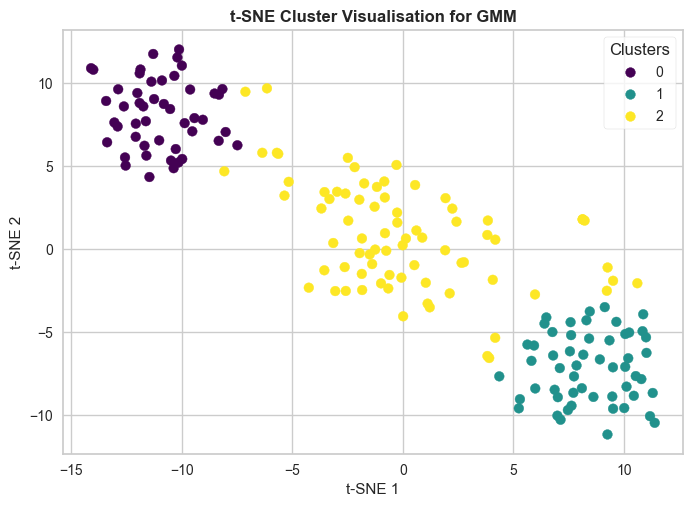

In [14]:
# Create paramater grid GMM hyperparameter tuning
param_grid = {
    "n_components": np.arange(2, 6),
    "covariance_type": ["full", "tied", "diag", "spherical"],
}


# Create custom BIC scorer for GMM hyperparameter tuning
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximise
    return -estimator.bic(X)


# Initiate GMM model and perform hyperparameter tuning
gmm = GaussianMixture(random_state=10)
gmm_grid = GridSearchCV(gmm, param_grid=param_grid, scoring=gmm_bic_score)
gmm_grid.fit(X_scaled)
logger.info(f"Best parameters: {gmm_grid.best_params_}")
y_gmm = gmm_grid.predict(X_scaled)

# Calculate clustering metrics
calculate_cluster_metrics(model="GMM", y_pred=y_gmm)

# Visualise clusters using t-SNE
generate_cluster_plot(model="GMM", y_pred=y_gmm)

plt.show()

Based on the results of the best-performing GMM model, with `covariance_type = spherical` and `n_components = 3`, the model appears to deliver strong performance, with evaluation scores being marginally lower than that of KMeans.

This suggests that both KMeans and GMMs are viable options for clustering the wine dataset, with GMMs providing a comparable alternative for uncovering the underlying structure of the data.

## Agglomerative Clustering

In this section, we apply agglomerative clustering to the wine dataset. Agglomerative clustering is a hierarchical clustering technique that employs a bottom-up approach where each data point initially starts as its own cluster. Clusters are then iteratively merged based on similarity, typically measured using Euclidean distance.

The algorithm works as follows:
1. __Pairwise Distance Calculation__: At each step, the pairwise distances between clusters are calculated using a specified distance metric (e.g., Euclidean distance).

2. __Cluster Merging__: The two closest clusters are merged based on the chosen linkage criterion:
	- __Ward__: Minimises the variance within merged clusters.
	- __Complete__: Uses the maximum distance between points in two clusters.
	- __Average__: Uses the average distance between all pairs of points in two clusters.
	- __Single__: Uses the minimum distance between points in two clusters.

3. __Distance Matrix Update__: After merging, the distances between the newly formed cluster and all remaining clusters are recalculated.

4. __Termination__: The process continues until the desired number of clusters (`n_clusters`) is formed.

To determine the optimal hyperparameters for the model (e.g., number of clusters and linkage criterion), we use `GridSearchCV` with multiple evaluation metrics as scoring functions. By iterating over various combinations of parameters, we identify the configuration where the metrics converge, providing the best clustering solution.

Finally, the performance of the tuned model is assessed using the same evaluation metrics as before (e.g., silhouette coefficient, Davies-Bouldin score, AMI, and Fowlkes-Mallows score) to ensure a fair comparison with other clustering algorithms.

In [15]:
# Create paramater grid agglomerative clustering hyperparameter tuning
param_grid = {
    "n_clusters": range(2, 6),
    "linkage": ["ward", "complete", "average", "single"],
}


# Define the custom scoring function for Silhouette Score
def silhouette_scorer(estimator, X, *args):
    """Callable to pass to GridSearchCV that will use the Silhouette score."""
    # Fit the model and predict the cluster labels
    pred = estimator.fit_predict(X)
    # Calculate and return the silhouette score (higher is better)
    return silhouette_score(X, pred)


# Define a custom scorer for Adjusted Mutual Information Score
def ami_scorer(estimator, X, y):
    """Callable to pass to GridSearchCV that will use the AMI score."""
    # Predict cluster labels
    pred = estimator.fit_predict(X)  # Use fit_predict for AgglomerativeClustering
    # Calculate Adjusted Mutual Information Score
    return adjusted_mutual_info_score(y, pred)


# Define a custom scorer for Fowlkes-Mallows Score
def fms_scorer(estimator, X, y):
    """Callable to pass to GridSearchCV that will use the FM score."""
    # Predict cluster labels
    pred = estimator.fit_predict(X)  # Use fit_predict for AgglomerativeClustering
    # Calculate Fowlkes-Mallows Score
    return fowlkes_mallows_score(y, pred)


# Define a custom scorer for Davies-Bouldin Score
def db_scorer(estimator, X, y):
    """Callable to pass to GridSearchCV that will use the FM score."""
    # Predict cluster labels
    pred = estimator.fit_predict(X)  # Use fit_predict for AgglomerativeClustering
    # Calculate Davies-Bouldin Score
    return -davies_bouldin_score(X, pred)


# Set up GridSearchCV with custom scorers
agg_cluster = AgglomerativeClustering()

for scorer in [silhouette_scorer, db_scorer, ami_scorer, fms_scorer]:
    logger.debug(
        f"Evaluating Agglomerative Clustering algorithm using {scorer.__name__}"
    )
    agg_grid = GridSearchCV(
        estimator=agg_cluster,
        param_grid=param_grid,
        scoring=lambda est, X: scorer(est, X_scaled, y_actual),
        cv=None,
    )

    # Fit grid
    agg_grid.fit(X_scaled)

    # Output best parameters and best score
    logger.info(f"Best parameters: {agg_grid.best_params_}")
    logger.info(f"Best {scorer.__name__} score: {agg_grid.best_score_:.2f}")

2025-01-25 12:20:35.817 | DEBUG    | __main__:<module>:48 - Evaluating Agglomerative Clustering algorithm using silhouette_scorer
2025-01-25 12:20:36.091 | INFO     | __main__:<module>:62 - Best parameters: {'linkage': 'ward', 'n_clusters': 3}
2025-01-25 12:20:36.093 | INFO     | __main__:<module>:63 - Best silhouette_scorer score: 0.28
2025-01-25 12:20:36.093 | DEBUG    | __main__:<module>:48 - Evaluating Agglomerative Clustering algorithm using db_scorer
2025-01-25 12:20:36.198 | INFO     | __main__:<module>:62 - Best parameters: {'linkage': 'average', 'n_clusters': 2}
2025-01-25 12:20:36.199 | INFO     | __main__:<module>:63 - Best db_scorer score: -0.59
2025-01-25 12:20:36.199 | DEBUG    | __main__:<module>:48 - Evaluating Agglomerative Clustering algorithm using ami_scorer
2025-01-25 12:20:36.303 | INFO     | __main__:<module>:62 - Best parameters: {'linkage': 'ward', 'n_clusters': 3}
2025-01-25 12:20:36.303 | INFO     | __main__:<module>:63 - Best ami_scorer score: 0.78
2025-01-2

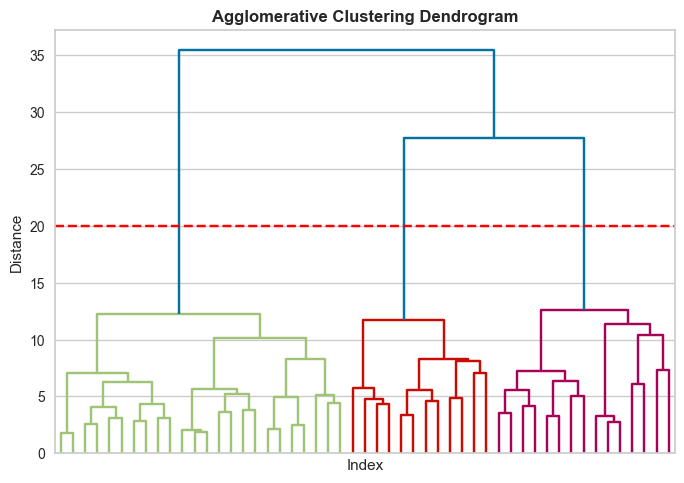

In [16]:
# Generate agglomerative linkage matrix
linkage_matrix = linkage(X_scaled, method="ward", metric="euclidean")

# Plot dendrogram
dendrogram(linkage_matrix, p=5, truncate_mode="level", no_labels=True)
plt.title("Agglomerative Clustering Dendrogram", fontweight="bold")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.axhline(y=20, color="red", linestyle="--")

plt.show()

Based on the results from `GridSearchCV`, the silhouette score, AMI score, and Fowlkes-Mallows score indicate that the best performance is achieved with `linkage = ward` and `n_clusters = 3`. This is further supported by the dendrogram, which visualises the hierarchical merging process in agglomerative clsutering, generated using Ward linkage, where the largest vertical gap between nodes suggests 3 clusters. A horizontal line passing through this gap intersects 3 branches, confirming the choice of `n_clusters = 3`.

Thus, we will proceed to build the agglomerative clustering model with the above hyperparameters and evaluate its performance in comparison to other clustering models.

2025-01-25 12:20:36.444 | DEBUG    | __main__:calculate_cluster_metrics:11 - Evaluating Agglomerative Clustering...
2025-01-25 12:20:36.446 | INFO     | __main__:calculate_cluster_metrics:15 - Silhouette coefficient = 0.28
2025-01-25 12:20:36.448 | INFO     | __main__:calculate_cluster_metrics:21 - Davies-Bouldin score = 1.42
2025-01-25 12:20:36.449 | INFO     | __main__:calculate_cluster_metrics:27 - Adjusted mutual information score = 0.78
2025-01-25 12:20:36.450 | INFO     | __main__:calculate_cluster_metrics:33 - Fowlkes-Mallows score = 0.86


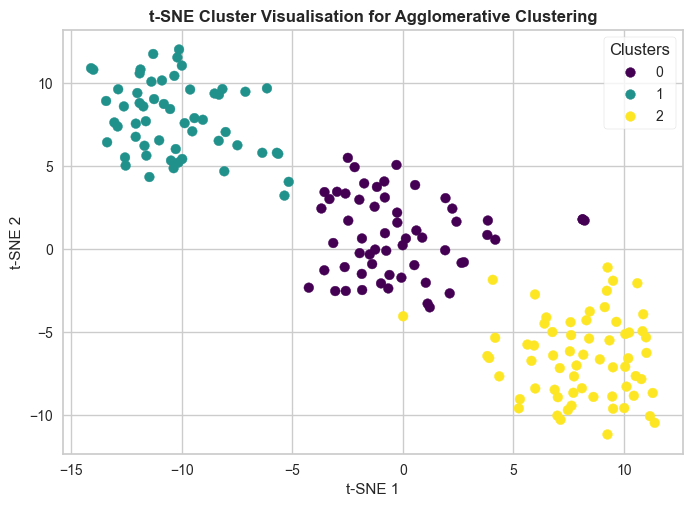

In [17]:
# Instantiate Agg Cluster model
agg_cluster = AgglomerativeClustering(n_clusters=3, linkage="ward")
y_agg = agg_cluster.fit_predict(X_scaled)

# Calculate clustering metrics
calculate_cluster_metrics(model="Agglomerative Clustering", y_pred=y_agg)

# Visualise clusters using t-SNE
generate_cluster_plot(model="Agglomerative Clustering", y_pred=y_agg)

The agglomerative clustering model produced results comparable to KMeans, with notable differences only appearing when using similarity indices for performance evaluation. However, in the absence of actual labels, the agglomerative model performs just as well as KMeans and GMMs, as indicated by similar silhouette scores and Davies-Bouldin scores.

This performance similarity could be attributed to the use of Ward’s linkage, which minimises the variance within merged clusters, resulting in compact, spherical clusters similar to those generated by KMeans. Additionally, when the underlying data naturally contains compact or spherical clusters, both methods tend to converge to similar outcomes. Despite agglomerative clustering’s ability to identify arbitrary cluster shapes, it may yield comparable results to KMeans and GMMs when the cluster structures in the data align with these models’ assumptions.

# 5. Conclusion <a id = '5'></a> 

Based on the evaluation of the four models: KMeans, DBSCAN, GMM, and Agglomerative Clustering, KMeans delivered the best performance, followed by GMM, Agglomerative Clustering, and DBSCAN. The table below summarises the evaluation metrics for each model’s predictions, compared against the actual labels as a baseline.

| Evaluation Metric | KMeans | DBSCAN | GMM | Agglomerative Clustering | Actual Labels |
| ---------- | :----------: | :----------: | :----------: | :----------: | :----------: |
| Silhouette Coefficient | 0.29 | 0.26 | 0.27 | 0.28 | 0.28 |
| Davies-Bouldin Score | 1.39 | 1.86 | 1.41 | 1.42 | 1.41 |
| Adjusted Mutual Information Score | 0.89 | 0.03 | 0.85 | 0.78 | 1.00 |
| Fowlkes-Mallows score | 0.94 | 0.56 | 0.92 | 0.86 | 1.00 |

In conclusion, we recommend using `n_clusters = 3` with either KMeans, GMM, or Agglomerative Clustering. For larger datasets, KMeans is the preferred method due to its computational efficiency. It calculates simple distances between points and centroids, making it scalable for larger datasets. Additionally, KMeans performs particularly well with spherical clusters, which appears to align with the structure of the clusters in this wine dataset.